<a href="https://colab.research.google.com/github/song23jihye/aid_steamtrap/blob/master/mae_test_jh_1103.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#모듈 사용

import os
os.chdir('/content/drive/MyDrive/steam_trap_project')

In [ ]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import os
import math
from torch.nn.parameter import Parameter
#from matplotlib import rcb

from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from torch import nn, optim
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from models.entropy_loss import EntropyLossEncap
from models.memae_2dmlp_conv import AutoEncoderCov2DMem
from sklearn.preprocessing import MinMaxScaler
from models.memory_module_series import MemModule
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 15, 8

In [ ]:
class opt():
    channels=1
    img_size=256
    lr = 1e-4
    n_epochs = 50
    batch_size=4
    chnum_in_ = 1     # channel number of the input images
    mem_dim_in = 2000
    entropy_loss_weight = 0.0002
    sparse_shrink_thres = 0.0025
    series_w = 1*(0.095/0.015)
    seed=42

#데이터 로드 & split training set and part of test set in normal samples

In [ ]:
#전처리
np.random.seed(opt.seed)
torch.manual_seed(opt.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df_normal_vibration = pd.read_csv('./CWRU/normal_data.csv',header=None) #S3에서 읽어오기
df_anormal_vibration = pd.read_csv('./CWRU/abnormal_data.csv',header=None) #S3에서 읽어오기

for col in df_normal_vibration.columns:
    df_normal_vibration[col] = pd.to_numeric(df_normal_vibration[col], errors='coerce') #to_numeric?
for col in df_anormal_vibration.columns:
    df_anormal_vibration[col] = pd.to_numeric(df_anormal_vibration[col], errors='coerce') #to_numeric?
df_all = pd.concat([df_normal_vibration, df_anormal_vibration], ignore_index=True) #정상과 비정상 concat

normal_num = len(df_normal_vibration) #정상 갯수
abnormal_num = len(df_anormal_vibration) #비정상 갯수

#df_normal_vibration과 df_anormal_vibration

In [32]:
#-----------------훈련-train_test_split, concat------------
train_df, test_df = train_test_split(
  df_normal_vibration,
  test_size=0.2,
  random_state=opt.seed)
print(f"train_df의 len:{len(train_df)}")

test_df = pd.concat([test_df, df_anormal_vibration], ignore_index=True)
#----------------------------------------------------------

train_df의 len:303


#이미지 불러오기? 이게 필요한가? 훈련에만 필요한 거 아님?

In [26]:
#Reading processed images
normal_path = "./CWRU/normal_img"
test_path = "./CWRU/unseen_img"
normal_data = []
normal_label = [] #라벨?
test_data = []
test_label = [] #***is the test set label(0 or 1)***

for filename in os.listdir(normal_path):
    if filename.endswith(".jpg"):
        img_path = os.path.join(normal_path, filename)
        img = Image.open(img_path)
        img = img.convert('L')
        img = img.resize((opt.img_size, opt.img_size))
        normal_data.append(img)
        normal_label.append(0)
num_normal = 0
num_abnormal = 0

# Get a list of all .jpg filenames
jpg_filenames = [filename for filename in os.listdir(test_path) if filename.endswith(".jpg")]

# Sort the filenames based on the integer value from int(filename.split('_')[0])
sorted_filenames = sorted(jpg_filenames, key=lambda filename: int(filename.split('_')[0]))

for filename in sorted_filenames:
    img_path = os.path.join(test_path, filename)
    img = Image.open(img_path)
    img = img.convert('L')
    img = img.resize((opt.img_size, opt.img_size))
    test_data.append(img)
    label = int(filename.split('_')[1][0])
    if label == 0:
        num_normal += 1
    else:
        num_abnormal += 1
    test_label.append(label)

#스펙트럼 계수 계산

In [36]:
#spectral entrophy 계산 for the training set, independent of read data--------------------------------------------
import numpy as np
from scipy.fft import fft

def spectral_entropy(signal, normalize=False):
    # Using FFT to calculate the spectrum of signals
    freq_domain = fft(signal)
    # 스펙트럼의 진폭을 계산하고 복잡한 부분을 제거합니다
    magnitude = np.abs(freq_domain)
    # amplitude normalization
    if normalize:
        magnitude = magnitude / np.sum(magnitude)
    # computational spectral entropy
    entropy = -np.sum(magnitude*np.log2(magnitude + np.finfo(float).eps))
    return entropy

In [37]:
#엔트로피_train, test
#train_entropies = []
test_entropies = []
for i in range(test_df.shape[0]): #testdata의 entropy 계산
    row_data = test_df.iloc[i].values  # iloc을 사용하여 line i의 값을 구하고 NumPy 배열로 변환합니다
    entropy = spectral_entropy(row_data, normalize=True)
    test_entropies.append(entropy)

# for i in range(train_df.shape[0]): #traindata의 entropy계산
#     row_data = train_df.iloc[i].values  # iloc를 사용하여 i번째 행의 값을 가져오고 NumPy 배열로 변환합니다.
#     entropy = spectral_entropy(row_data, normalize=True)
#     train_entropies.append(entropy)
# average_entropy = np.mean(train_entropies)

#print(f"train_dataset의 평균 스펙트럼 엔트로피는 {average_entropy}입니다.")
#-----------------------------------------------------------------------------------------------------------------#

In [38]:
average_entropy = np.mean(test_entropies)
print(f"test_dataset의 평균 스펙트럼 엔트로피는 {average_entropy}입니다.")

test_dataset의 평균 스펙트럼 엔트로피는 7.829500717005006입니다.


#Recalling Fig.8 and 9. Wrapping data into data_loader

In [33]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences,img,labels=None,transform=None):
        self.sequences = sequences
        self.transform = transform
        self.img = img
        self.labels = labels
    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        img = self.img[index]
        labels = self.labels[index]

        if self.transform:
            img = self.transform(img)
        return self.sequences[index],img,labels

mean = [0.5]
std = [0.5]
def create_train_data_loader(df, batch_size,img,labels):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = TimeSeriesDataset([torch.tensor(s).unsqueeze(1).float() for s in sequences],img,labels,transform=transforms.Compose(
                                    [
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=mean, std=std)]))
    return DataLoader(dataset, batch_size=batch_size, shuffle=False,drop_last=False)

def create_test_data_loader(df,batch_size,img,labels):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = TimeSeriesDataset([torch.tensor(s).unsqueeze(1).float() for s in sequences],img,labels,transform=transforms.Compose(
                                    [
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=mean, std=std)]))
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

train_dataloader = create_train_data_loader(train_df, 1, normal_data, normal_label) #훈련 아니니까 사용x
test_dataloader = create_test_data_loader(test_df, 1 , test_data, test_label) # 얘만 사용

#Encoder, Decoder, AutoEncoder 클래스

In [ ]:
# Modified Encoder with Fully Connected Layers
class Encoder1(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=128,dropout_prob=0.0):
        super(Encoder1, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim
        self.dropout = nn.Dropout(dropout_prob)
        # You might need to adjust the sizes here to fit your needs.
        self.fc1 = nn.Linear(self.n_features, self.hidden_dim) #seq_len * n_features
        self.fc2 = nn.Linear(self.hidden_dim, self.embedding_dim * n_features)

    def forward(self, x):
        try:
            B, S, E = x.shape  # B = Batch size, S = Sequence length, E = Feature dim
        except:
            B = 1
        x = x.view(B, -1)  # Flatten the input: shape becomes (B, S*E)
        x = x.unsqueeze(-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # Here, we reshape the output to mimic your original Encoder's output shape
        x = x.view(B, self.seq_len, self.embedding_dim)
        return x


# Modified Decoder with Fully Connected Layers
class Decoder1(nn.Module):
    def __init__(self, seq_len, input_dim=128, n_features=1):
        super(Decoder1, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim  # Embedding dim from Encoder
        self.hidden_dim = 2 * input_dim  # Mimicking original architecture
        self.n_features = n_features  # Usually 1, representing the reconstructed feature
        self.fc1 = nn.Linear(self.input_dim * seq_len, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, seq_len * n_features)
        self.output_layer = nn.Linear(seq_len * n_features, seq_len * n_features)

    def forward(self, x): #모델 정의
        B,E,G = x.shape
        #x = x.repeat(1,self.seq_len, self.n_features)
        #x = x.reshape((B, self.input_dim,1))
        x = x.reshape(B, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output_layer(x)

        # Reshape to mimic your original Decoder's output shape
        x = x.view(B, self.seq_len, self.n_features)
        return x

class Autoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder1(seq_len, n_features, embedding_dim)
        self.decoder = Decoder1(seq_len, embedding_dim, n_features)
        self.mem_rep = MemModule(mem_dim=500, fea_dim=1280, shrink_thres=0.0025)

    def forward(self, x):
        x = self.encoder(x)
        res_mem = self.mem_rep(x)
        x = res_mem['output']
        att = res_mem['att']
        x = self.decoder(x)
        return x, att

#predict

In [39]:
def predict(model_series,model_img,dataloader):
    entropy_loss_weight=0.0002
    predictions, losses = [], []
    tr_recon_loss_func = nn.MSELoss().to(device)  ###nn.MSELoss().to(device)#
    tr_entropy_loss_func = EntropyLossEncap().to(device)
    criterion = nn.MSELoss().to(device)##nn.MSELoss().to(device)
    with torch.no_grad():
        for batch_idx, (seq_true,frames,labels) in enumerate(dataloader):
            frames = frames.to(device)
            # frq_entropy = train_entropies[batch_idx]
            frq_entropy = test_entropies[batch_idx]
            frq_entropy = (frq_entropy+average_entropy)/2
            seq_true = seq_true.to(device)
            labels = labels.to(device).float()
            #print('frames:',frames.shape)
            recon_res = model_img(frames)
            seq_pred, att_w1 = model_series(seq_true)
            recon_frames = recon_res['output']
            r_frame = recon_frames - frames
            sp_error_map = torch.sum(r_frame**2, dim=1)**0.5
            s = sp_error_map.size()
            sp_error_vec = sp_error_map.view(s[0], -1)
            recon_error_frame = torch.mean(sp_error_vec, dim=-1)
            recon_error_series = tr_recon_loss_func(seq_pred, seq_true)
            recon_error = frq_entropy*recon_error_frame + opt.series_w*recon_error_series
            #predictions.append(img_pred.cpu().numpy().flatten())
            losses.append(recon_error.item())
    return predictions, losses

#모델 load

In [28]:
model_series = Autoencoder(seq_len=1280, n_features=1, embedding_dim=400).to(device)
model_img = AutoEncoderCov2DMem(opt.chnum_in_, opt.mem_dim_in, shrink_thres=opt.sparse_shrink_thres).to(device)

model_series = torch.load('/content/drive/MyDrive/steam_trap_project/mdlpth/mae_vibration_series_model.pth', map_location=device)
model_img = torch.load('/content/drive/MyDrive/steam_trap_project/mdlpth/mae_vibration_img_model.pth', map_location=device)

model_series.to(device)
model_img.to(device)
model_series.eval()
model_img.eval()

AutoEncoderCov2DMem


<ipython-input-40-8544b88fa0a3>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=150, kde=True);


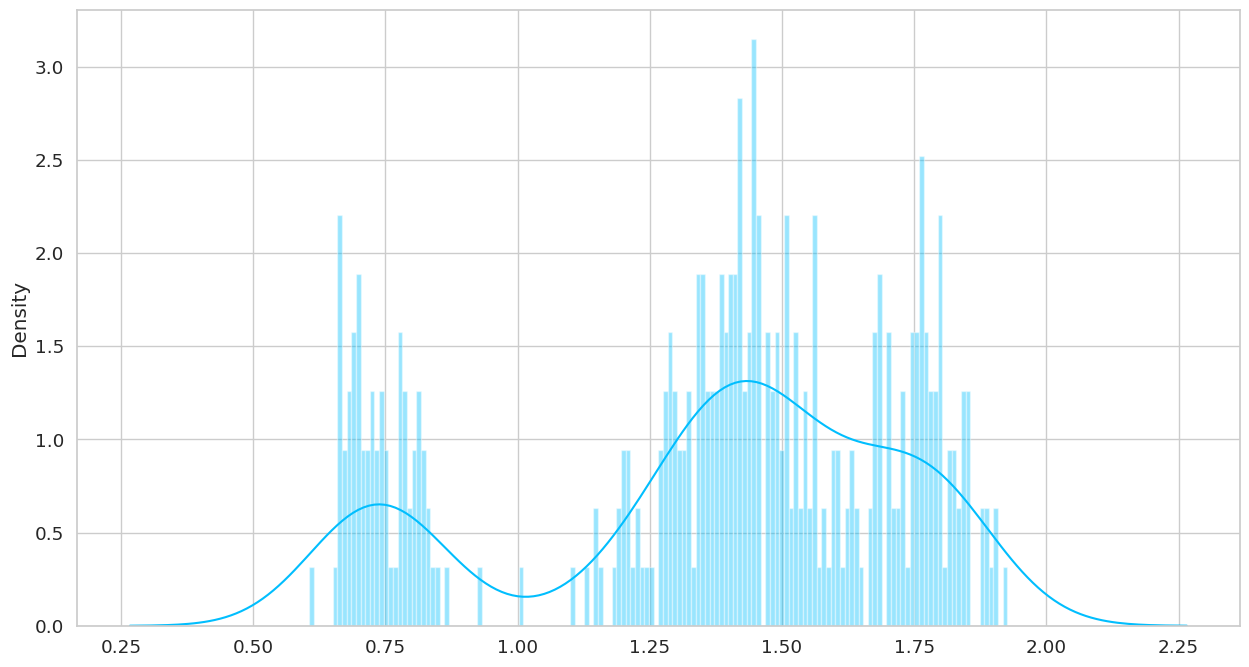

In [40]:
tr_recon_loss_func = nn.MSELoss().to(device)
tr_entropy_loss_func = EntropyLossEncap().to(device)
entropy_loss_weight = 0.0002
#_, losses = predict(model_series,model_img, train_dataloader) #train X
_, losses = predict(model_series,model_img, test_dataloader) #test만 사용
sns.distplot(losses, bins=150, kde=True);

#losses 시각화

In [ ]:
df = pd.DataFrame(losses)
print(df.describe())
df.plot.box(title="Box Chart")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

#정확도?

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
THRESHOLD =0.78

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    predicted = []
    Label=[]
    Recon_error_true = []
    Recon_error_false = []
    num = 0
    for batch_idx, (seq_true,frames,labels) in enumerate(test_dataloader): #seq_true : time series data in test_dataloader, #frames : image data in test_dataloader
        num+=1
        frames = frames.to(device)
        frq_entropy = test_entropies[batch_idx]
        frq_entropy = (frq_entropy+average_entropy)/2
        seq_true = seq_true.to(device)
        labels = labels.to(device).float()
        #print('frames:',frames.shape)
        recon_res = model_img(frames)
        seq_pred, att_w1 = model_series(seq_true)
        recon_frames = recon_res['output']
        r_frame = recon_frames - frames
        sp_error_map = torch.sum(r_frame**2, dim=1)**0.5
        s = sp_error_map.size()
        sp_error_vec = sp_error_map.view(s[0], -1)
        recon_error_frame = torch.mean(sp_error_vec, dim=-1)
        recon_error_series = tr_recon_loss_func(seq_pred, seq_true)
        recon_error = frq_entropy*recon_error_frame + opt.series_w*recon_error_series
        if labels == 0:
            Recon_error_true.append(recon_error.cpu().numpy())
        else:
            Recon_error_false.append(recon_error.cpu().numpy())
        if recon_error > THRESHOLD:
            predicted.append(1)
        else:
            predicted.append(0)
        Label.append(labels.cpu().numpy())
    f1 = f1_score(Label, predicted)
    print('F1 Score: ', f1)
    report = classification_report(Label, predicted, target_names=["Normal", "Anomaly"], output_dict=True)
    for key, values in report.items():
        if isinstance(values, dict):
            for sub_key, value in values.items():
                report[key][sub_key] = round(value, 4)
        else:
            report[key] = round(values, 4)

    print(report)

F1 Score:  0.9792387543252596
{'Normal': {'precision': 0.9706, 'recall': 0.8684, 'f1-score': 0.9167, 'support': 76.0}, 'Anomaly': {'precision': 0.9659, 'recall': 0.993, 'f1-score': 0.9792, 'support': 285.0}, 'accuracy': 0.9668, 'macro avg': {'precision': 0.9682, 'recall': 0.9307, 'f1-score': 0.948, 'support': 361.0}, 'weighted avg': {'precision': 0.9669, 'recall': 0.9668, 'f1-score': 0.9661, 'support': 361.0}}


#결과 시각화?

/tmp/ipykernel_784114/4036872239.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Recon_error_true, bins=50, kde=True, label='Normal', color='blue')
/tmp/ipykernel_784114/4036872239.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Recon_error_false, bins=50, kde=True, label='Anomaly', colo

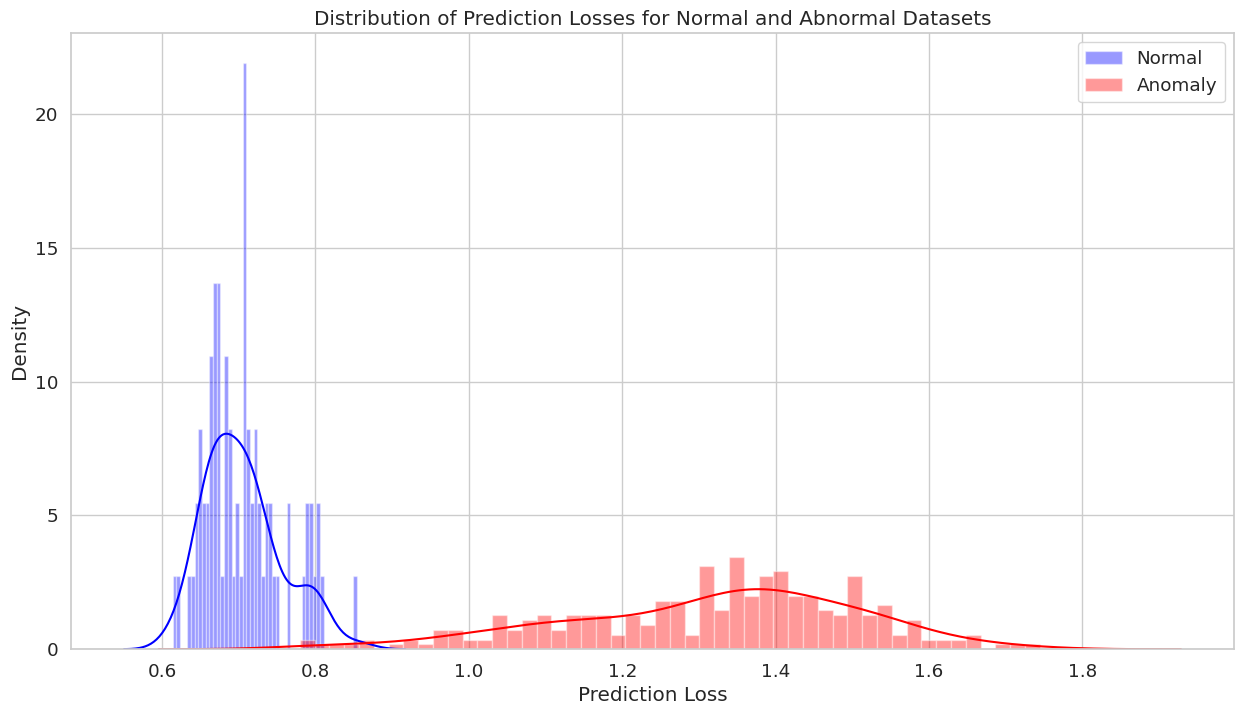

In [ ]:
sns.distplot(Recon_error_true, bins=50, kde=True, label='Normal', color='blue')

# Plotting the anomaly dataset predictions
sns.distplot(Recon_error_false, bins=50, kde=True, label='Anomaly', color='red')

# Adding labels and title to the plot
plt.xlabel('Prediction Loss')
plt.ylabel('Density')
plt.title('Distribution of Prediction Losses for Normal and Abnormal Datasets')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

## Img model only

In [ ]:
THRESHOLD = 0.095

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    predicted = []
    Label=[]
    Recon_error_true = []
    Recon_error_false = []
    num = 0
    for batch_idx, (seq_true,frames,labels) in enumerate(test_dataloader):
        num+=1
        frames = frames.to(device)
        seq_true = seq_true.to(device)
        labels = labels.to(device).float()
        #print('frames:',frames.shape)
        recon_res = model_img(frames)
        seq_pred, att_w1 = model_series(seq_true)
        recon_frames = recon_res['output']
        r_frame = recon_frames - frames
        sp_error_map = torch.sum(r_frame**2, dim=1)**0.5
        s = sp_error_map.size()
        sp_error_vec = sp_error_map.view(s[0], -1)
        recon_error_frame = torch.mean(sp_error_vec, dim=-1)
        recon_error_series = tr_recon_loss_func(seq_pred, seq_true)
        recon_error = recon_error_frame #+ opt.series_w*recon_error_series
        if labels == 0:
            Recon_error_true.append(recon_error.cpu().numpy())
        else:
            Recon_error_false.append(recon_error.cpu().numpy())
        if recon_error > THRESHOLD:
            predicted.append(1)
        else:
            predicted.append(0)
        Label.append(labels.cpu().numpy())
    f1 = f1_score(Label, predicted)
    print('F1 Score: ', f1)
    report = classification_report(Label, predicted, target_names=["Normal", "Anomaly"], output_dict=True)
    for key, values in report.items():
        if isinstance(values, dict):
            for sub_key, value in values.items():
                report[key][sub_key] = round(value, 4)
        else:
            report[key] = round(values, 4)

    print(report)

In [ ]:
sns.distplot(Recon_error_true, bins=50, kde=True, label='Normal', color='blue')

# Plotting the anomaly dataset predictions
sns.distplot(Recon_error_false, bins=50, kde=True, label='Anomaly', color='red')

# Adding labels and title to the plot
plt.xlabel('Prediction Loss')
plt.ylabel('Density')
plt.title('Distribution of Prediction Losses for Normal and Abnormal Datasets')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()